In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import json
from pandas import json_normalize

import datetime as dt

import geopandas as gpd
from geopandas import GeoDataFrame

from shapely.geometry import Point

from openaq import OpenAQ


from dotenv import load_dotenv 
import os 

https://www.codecademy.com/article/python-environment-variables

In [11]:
load_dotenv()

api_key = os.getenv("openaq_key") 
debug = os.getenv("DEBUG", "False") 

In [12]:
client = OpenAQ(api_key)

In [2]:
la_bounds = gpd.read_file("../../Data/Vectors/LA_Boundary/la_mainland.geojson")

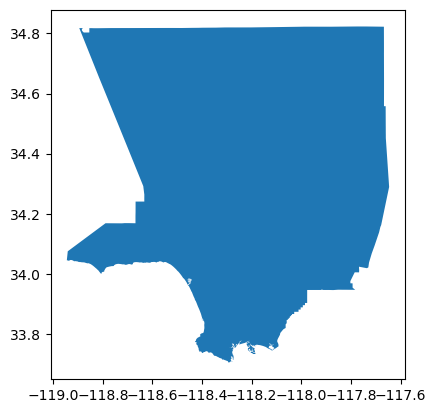

In [6]:
la_bounds.plot();

In [3]:
la_bounds.keys()

Index(['OBJECTID', 'OBJECTID_1', 'TYPE', 'NAME', 'ShapeSTAre', 'ShapeSTLen',
       'ORIG_FID', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [4]:
bbox = la_bounds.bounds.values[0]

In [5]:
bbox

array([-118.94470305,   33.70467437, -117.64638598,   34.82330416])

This has to be converted to a list of floats before it can be passed into the API:

In [6]:
bbox = [float(bbox[i]) for i in range(len(bbox))]

In [7]:
bbox

[-118.94470304698112,
 33.704674372238884,
 -117.64638597948213,
 34.823304156658715]

In [8]:
la_bounds.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We are passing in the bounding box from the outline of LA County to limit the OpenAQ API to only return metadata on stations from within this boundary:

In [13]:
response = client.locations.list(
    bbox=bbox,
    limit=1000
)
data = response.dict()
stations_df = json_normalize(data['results'])

Notably, this dataset only contains metadata on the OpenAQ stations, not actual sensor readings

In [14]:
stations_df.head(3)

,id,name,locality,timezone,is_mobile,is_monitor,instruments,sensors,bounds,distance,...,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_first.local,datetime_last.utc,datetime_last.local,datetime_first,datetime_last
0,847,South Long Beach,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1502, 'name': 'pm25 µg/m³', 'parameter...","[-118.175278, 33.792221, -118.175278, 33.792221]",None,...,119,AirNow,33.792221,-118.175278,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2022-05-05T22:00:00Z,2022-05-05T15:00:00-07:00,NaN,NaN
1,1019,Pasadena,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1837, 'name': 'o3 ppm', 'parameter': {...","[-118.1081, 34.0833, -118.1081, 34.0833]",None,...,119,AirNow,34.083300,-118.108100,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2016-11-09T21:00:00Z,2016-11-09T13:00:00-08:00,NaN,NaN
2,1036,Pico Rivera,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1866, 'name': 'o3 ppm', 'parameter': {...","[-118.059196, 34.0131, -118.059196, 34.0131]",None,...,119,AirNow,34.013100,-118.059196,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2016-11-09T21:00:00Z,2016-11-09T13:00:00-08:00,NaN,NaN


In [10]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     436 non-null    int64  
 1   name                   436 non-null    object 
 2   locality               39 non-null     object 
 3   timezone               436 non-null    object 
 4   is_mobile              436 non-null    bool   
 5   is_monitor             436 non-null    bool   
 6   instruments            436 non-null    object 
 7   sensors                436 non-null    object 
 8   bounds                 436 non-null    object 
 9   distance               0 non-null      object 
 10  country.id             436 non-null    int64  
 11  country.code           436 non-null    object 
 12  country.name           436 non-null    object 
 13  owner.id               436 non-null    int64  
 14  owner.name             436 non-null    object 
 15  provid

I will convert this to a geodataframe using the lat and long columns:

https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

In [11]:
stations_gdf = gpd.GeoDataFrame(
    stations_df, geometry=gpd.points_from_xy(stations_df['coordinates.longitude'], stations_df['coordinates.latitude']), crs="EPSG:4326"
)

In [12]:
stations_gdf.to_file("../../Data/vectors/stations_gdf.geojson", driver="GeoJSON")

There are several columns which have large amounts of null entries and don't add much to the dataset, so I will drop them. I will also drop the local datetime features and only use the `UTC` ones:

In [13]:
stations_gdf.drop(columns=['locality','distance','datetime_first','datetime_last','datetime_first.local','datetime_last.local'],inplace=True)

In [14]:
dt_cols = stations_gdf.columns[17:19]

In [15]:
dt_cols

Index(['datetime_first.utc', 'datetime_last.utc'], dtype='object')

In [16]:
for col in dt_cols:
    stations_gdf[col] = pd.to_datetime(stations_gdf[col])

In [17]:
stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     436 non-null    int64              
 1   name                   436 non-null    object             
 2   timezone               436 non-null    object             
 3   is_mobile              436 non-null    bool               
 4   is_monitor             436 non-null    bool               
 5   instruments            436 non-null    object             
 6   sensors                436 non-null    object             
 7   bounds                 436 non-null    object             
 8   country.id             436 non-null    int64              
 9   country.code           436 non-null    object             
 10  country.name           436 non-null    object             
 11  owner.id               436 non-null    int64      

The datetime features have some missing rows - any readings without a timestamp will be useless to me, so I will drop these:

In [18]:
stations_gdf.dropna(inplace=True)

In [19]:
stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 432 entries, 0 to 435
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     432 non-null    int64              
 1   name                   432 non-null    object             
 2   timezone               432 non-null    object             
 3   is_mobile              432 non-null    bool               
 4   is_monitor             432 non-null    bool               
 5   instruments            432 non-null    object             
 6   sensors                432 non-null    object             
 7   bounds                 432 non-null    object             
 8   country.id             432 non-null    int64              
 9   country.code           432 non-null    object             
 10  country.name           432 non-null    object             
 11  owner.id               432 non-null    int64           

In [20]:
stations_gdf.head()

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1502, 'name': 'pm25 µg/m³', 'parameter...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1837, 'name': 'o3 ppm', 'parameter': {...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1866, 'name': 'o3 ppm', 'parameter': {...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1876, 'name': 'o3 ppm', 'parameter': {...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)
4,1052,Pomona,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 25500, 'name': 'co ppm', 'parameter': ...","[-117.7506, 34.0667, -117.7506, 34.0667]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.066700,-117.750600,2016-03-06 20:00:00+00:00,2025-12-15 03:00:00+00:00,POINT (-117.7506 34.0667)


### Sensors feature

Currently, each station has a nested `sensors` feature which can contain multiple sensor readings corresponding to multiple pollutant types:

In [21]:
stations_gdf[stations_gdf['id'] == 1042]

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,geometry
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1876, 'name': 'o3 ppm', 'parameter': {...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.4044,-118.81,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)


In [22]:
stations_gdf[stations_gdf['id'] == 1042]['sensors'][3]

[{'id': 1876,
  'name': 'o3 ppm',
  'parameter': {'id': 10, 'name': 'o3', 'units': 'ppm', 'display_name': 'O₃'}},
 {'id': 22301,
  'name': 'pm25 µg/m³',
  'parameter': {'id': 2,
   'name': 'pm25',
   'units': 'µg/m³',
   'display_name': 'PM2.5'}}]

Exploding the `sensors` feature will give each sensor type its own separate row:

In [23]:
stations_gdf.explode('sensors').head()

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1502, 'name': 'pm25 µg/m³', 'parameter'...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1837, 'name': 'o3 ppm', 'parameter': {'...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1866, 'name': 'o3 ppm', 'parameter': {'...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1876, 'name': 'o3 ppm', 'parameter': {'...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 22301, 'name': 'pm25 µg/m³', 'parameter...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)


In [24]:
stations_explode = stations_gdf.explode('sensors')

I will also rename the existing `id` feature to make this more clear:

In [25]:
stations_explode.rename(columns={'id':'station_id'},inplace=True)

In [26]:
stations_explode.head()

,station_id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1502, 'name': 'pm25 µg/m³', 'parameter'...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1837, 'name': 'o3 ppm', 'parameter': {'...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1866, 'name': 'o3 ppm', 'parameter': {'...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1876, 'name': 'o3 ppm', 'parameter': {'...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 22301, 'name': 'pm25 µg/m³', 'parameter...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,POINT (-118.81 34.4044)


I will add a separate feature for the pollutant type represented by each sensor entry:

In [27]:
stations_explode['pollutant'] = [stations_explode.iloc[i]['sensors']['parameter']['display_name'] for i in range(len(stations_explode))]

And an id feature for each sensor, which I will set as the index:

In [28]:
stations_explode['sensors_id'] = [stations_explode.iloc[i]['sensors']['id'] for i in range(len(stations_explode))]

In [29]:
stations_explode.set_index(keys=['sensors_id'],inplace=True)

https://stackoverflow.com/questions/53141240/pandas-how-to-swap-or-reorder-columns

I will also reorder the columns:

In [30]:
cols = ['station_id','pollutant','name','datetime_first.utc','datetime_last.utc']
stations_explode = stations_explode[cols + [c for c in stations_explode.columns if c not in cols]]

I will also drop the old `sensors` feature:

In [31]:
stations_explode.drop(columns=['sensors'],inplace=True)

In [32]:
stations_explode.head(3)

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,instruments,bounds,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,geometry
sensors_id,,,,,,,,,,,,,,,,,,,,
1502,847,PM2.5,South Long Beach,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,POINT (-118.17528 33.79222)
1837,1019,O₃,Pasadena,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,POINT (-118.1081 34.0833)
1866,1036,O₃,Pico Rivera,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,United States,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,POINT (-118.0592 34.0131)


In [33]:
stations_explode['pollutant'].unique()

array(['PM2.5', 'O₃', 'CO', 'NO', 'NO₂', 'NOx', 'PM10', 'SO₂', 'PM1',
       'Temperature (F)', 'Temperature (C)', 'RH', 'PM0.3 count'],
      dtype=object)

Text(0.5, 1.0, 'OpenAQ Stations in LA County')

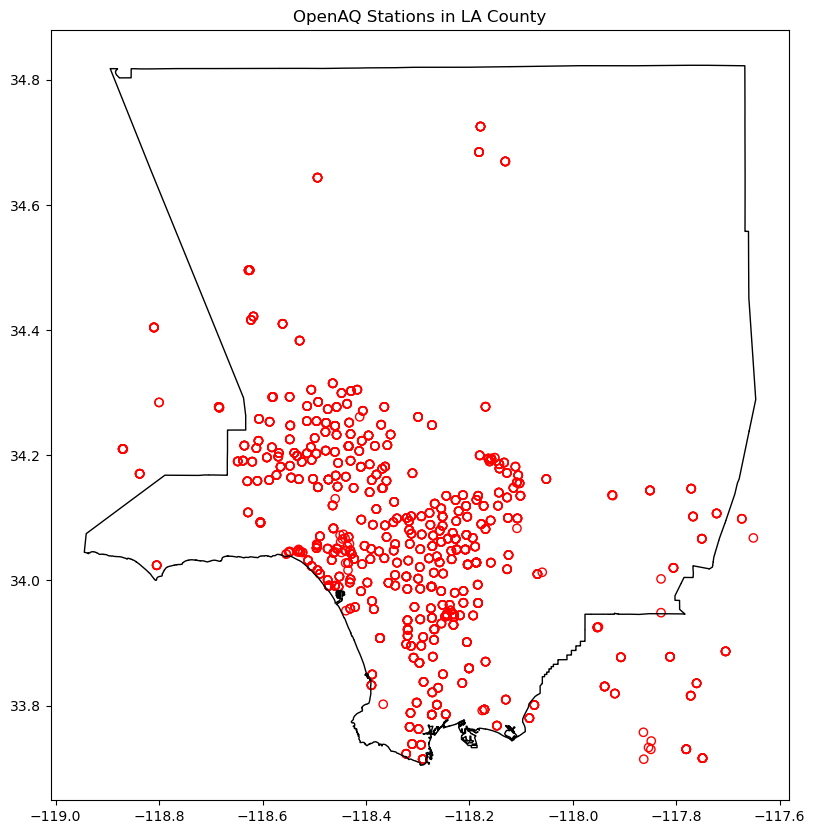

In [34]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
stations_explode.plot(ax=ax, color='none', edgecolor='red');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
ax.set_title('OpenAQ Stations in LA County')

### Instruments

This is another nested feature:

In [35]:
stations_explode['instruments'][:2]

sensors_id
1502    [{'id': 2, 'name': 'Government Monitor'}]
1837    [{'id': 2, 'name': 'Government Monitor'}]
Name: instruments, dtype: object

In [36]:
list(stations_explode['instruments'])[0][0]['name']

'Government Monitor'

These are all the names of instrument types in the dataset:

In [37]:
set([list(stations_explode['instruments'])[i][0]['name'] for i in range(len(list(stations_explode['instruments'])))])

{'Aerosol Black Carbon Detector (ABCD)',
 'AirGradient ONE Generation 9 (I-9PSL-DE)',
 'AirGradient Open Air Generation 1 (O-1PST)',
 'Clarity Sensor',
 'Government Monitor',
 'N/A',
 'Unknown AirGradient Sensor'}

Each row now corresponds to one sensor and therefore one instrument, so I don't need to explode it again.

I will create new features for `instrument_id` and `instrument_name` on the off chance they become relevant:

In [38]:
stations_explode['instrument_name'] = [list(stations_explode['instruments'])[i][0]['name'] for i in range(len(list(stations_explode['instruments'])))]

In [39]:
stations_explode['instrument_id'] = [list(stations_explode['instruments'])[i][0]['id'] for i in range(len(list(stations_explode['instruments'])))]

In [40]:
stations_explode[['station_id','name','instrument_name','instrument_id']]

,station_id,name,instrument_name,instrument_id
sensors_id,,,,
1502,847,South Long Beach,Government Monitor,2
1837,1019,Pasadena,Government Monitor,2
1866,1036,Pico Rivera,Government Monitor,2
1876,1042,Piru - Pacific,Government Monitor,2
22301,1042,Piru - Pacific,Government Monitor,2
...,...,...,...,...
14877257,6163000,Poinsettia & Cherry,Unknown AirGradient Sensor,7
14877258,6163000,Poinsettia & Cherry,Unknown AirGradient Sensor,7
14877259,6163000,Poinsettia & Cherry,Unknown AirGradient Sensor,7


I can now drop the old `instruments` feature so it's not nested anymore, and commit my work to a new dataframe:

In [41]:
stations_explode.drop(columns=['instruments'],inplace=True)

In [42]:
sensors_gdf = stations_explode

In [43]:
sensors_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1971 entries, 1502 to 14877261
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   station_id             1971 non-null   int64              
 1   pollutant              1971 non-null   object             
 2   name                   1971 non-null   object             
 3   datetime_first.utc     1971 non-null   datetime64[ns, UTC]
 4   datetime_last.utc      1971 non-null   datetime64[ns, UTC]
 5   timezone               1971 non-null   object             
 6   is_mobile              1971 non-null   bool               
 7   is_monitor             1971 non-null   bool               
 8   bounds                 1971 non-null   object             
 9   country.id             1971 non-null   int64              
 10  country.code           1971 non-null   object             
 11  country.name           1971 non-null   object 

Everything from here on will be part of the EDA notebook

In [47]:
sensors_gdf.to_file("../../Data/sensor_data/la_openaq_stations.geojson", driver="GeoJSON")

### Temperature

There are separate Temperature pollutant classes for celsius and farenheit.

In [ ]:
sensors_gdf[(sensors_gdf['pollutant'] == 'Temperature (C)') | (sensors_gdf['pollutant'] == 'Temperature (F)')].head(2)

This dataset is just metadata - it doesn't have actual sensor readings.

In [ ]:
sensors_gdf[(sensors_gdf['pollutant'] == 'Temperature (C)') | (sensors_gdf['pollutant'] == 'Temperature (F)')].head()

In [ ]:
sensors_gdf.loc[5244578]

In [ ]:
sensors_gdf.loc[5244579]

In [83]:
sensors_temp_c_gdf = sensors_gdf[sensors_gdf['pollutant'] == 'Temperature (C)']
sensors_temp_f_gdf = sensors_all_years_gdf[sensors_all_years_gdf['pollutant'] == 'Temperature (F)']

NameError: name 'sensors_gdf' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), label='Inline label',dpi=200);
sensors_temp_c_gdf.plot(ax=ax, color='none', edgecolor='green',label="Temperature (C)");
sensors_temp_f_gdf.plot(ax=ax, color='none', edgecolor='orange',label="Temperature (F)");
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
ax.set_title("Celsius vs Fahrenheit Sensors");
ax.legend(loc='best');

## Athena

The next section is for Athena and should be dropped since there's a separate notebook now

In [ ]:
cursor = connect(
    s3_staging_dir="s3://la-openaq-athena-results-us-east-1/temp/",
    region_name="us-east-1"
).cursor()

cursor.execute("DROP TABLE openaq_db.openaqMeasurements;")

In [ ]:
create_table = """
CREATE EXTERNAL TABLE IF NOT EXISTS openaq_db.openaqMeasurements (
  location_id INT,
  sensors_id INT,
  location STRING,
  datetime STRING,
  lat DOUBLE,
  lon DOUBLE,
  parameter STRING,
  units STRING,
  value DOUBLE
)
PARTITIONED BY (locationid STRING, year STRING, month STRING)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES ('serialization.format'=',','field.delim'=',')
LOCATION 's3://openaq-data-archive/records/csv.gz/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
cursor.execute(create_table)

month is handled as `str(today.month).zfill(2)` to ensure March -> 04

In [ ]:
for location in station_IDs:
    cursor.execute(f"""
    ALTER TABLE openaq_db.openaqMeasurements ADD
    PARTITION (year='{today.year}', month='{str(today.month).zfill(2)}', locationid='{location}')
    LOCATION 's3://openaq-data-archive/records/csv.gz/locationid={location}/year={today.year}/month={str(today.month).zfill(2)}/';
    """)

In [ ]:
cursor.execute(f"""
SELECT *
FROM (
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY sensors_id
               ORDER BY datetime DESC
           ) AS rn
    FROM openaq_db.openaqMeasurements
    WHERE year = '{today.year}'
      AND month = '{str(today.month).zfill(2)}'
      AND sensors_id IN {tuple(sensor_IDs)}
) sub
WHERE rn = 1
ORDER BY datetime DESC;
"""
)
records = cursor.fetchall()

In [ ]:
records[3]

In [ ]:
la_df = pd.DataFrame(data = records, columns=[
    "location_id", "sensors_id", "location", "datetime",
    "lat", "lon", "parameter", "units", "value",
    "partition_locationid", "year", "month", "day"
])
la_gdf = gpd.GeoDataFrame(
    la_df,
    geometry=[Point(xy) for xy in zip(la_df.lon, la_df.lat)],
    crs="EPSG:4326"
)


In [ ]:
la_gdf.head()

In [ ]:
la_gdf['datetime_utc'] = pd.to_datetime(la_gdf['datetime'])

In [ ]:
la_gdf.drop(columns=['partition_locationid','year','month','day','datetime','lat','lon'],inplace=True)

In [ ]:
la_gdf.info()

In [ ]:
la_gdf.columns[:-2]

In [ ]:
la_gdf.head()

In [ ]:
gdf.to_file('../Data/Outputs/la_gdf.gpkg', driver='GPKG', layer='outliers_la_gdf')

In [ ]:
la_gdf = gpd.read_file("../Data/Outputs/la_gdf.gpkg", layer='la_gdf')

In [ ]:
la_gdf['value'].mean()

Physically, it is impossible for us to have a valid reading with `>1000 µg/m³`. Regardless, we can use the inter-quartile range of the data, and clip anything beyond 1.5x of this middle 50%.

In [ ]:
la_gdf['value'].sort_values()

In [ ]:
Q1 = la_gdf['value'].quantile(0.25)
Q3 = la_gdf['value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

la_gdf_filtered = la_gdf[
    (la_gdf['value'] >= lower_bound) &
    (la_gdf['value'] <= upper_bound)
]


In [ ]:
la_gdf_filtered['value'].sort_values()

In [ ]:
la_gdf_filtered.to_file('../Data/Outputs/la_gdf.gpkg', driver='GPKG', layer='la_gdf_filtered')

In [ ]:
np.random.seed(3)
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');

for pollutant in list(pollutant_classes):
    la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
    sensors_all_years_gdf[sensors_all_years_gdf['pollutant'] == pollutant].plot(ax=ax, color=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                edgecolor=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                label=pollutant);
ax.set_title('Spatial coverage by sensor type for sensors with full temporal coverage (2016-2025)');
ax.legend();